In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# 합성곱 신경망
- 딥러닝이 잘 적용되는 분야
  - `비정형` 데이터(이미지, 영상, 음성, 자연어, ... )

- CNN(Convolution Neural Network)
  - 신경망(NN)을 구성하는 방법에 대한 얘기를 하는게 아닙니다.
  - NN은 앞에서 다뤘던 네트워크와 동일한 내용 입니다.
    - 즉, CNN이 사용하는 NN도 동일한 선형회귀 모형 입니다.
  - 이미지에 대한 특징을 추출하는 방법에 대한 내용이 NN 앞에서 추가가 되어 있습니다. 
    - `알고리즘 스스로 특징을 추출한다`라고 잘 알려져 있습니다.
    - 특징 추출 + 뉴럴넷

## 이미지 처리
- 이제는 이미지에 대한 전문지식이 없어도 전문가 처럼 이미지를 다룰 수 있습니다. 
- 수업시간에 사용할 자료는 MNIST 자료이고
  - 손글씩 분류로 잘 알려져 있습니다.
  - 딥러닝의 'Hello, World`라고 해서 딥러닝을 처음 해보는 경우 사용하는 학습 데이터

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### 이미지 확인

In [ ]:
y_train[0]

5

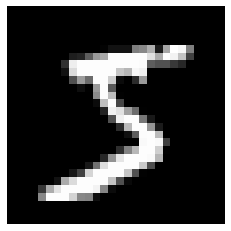

In [ ]:
plt.imshow( x_train[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

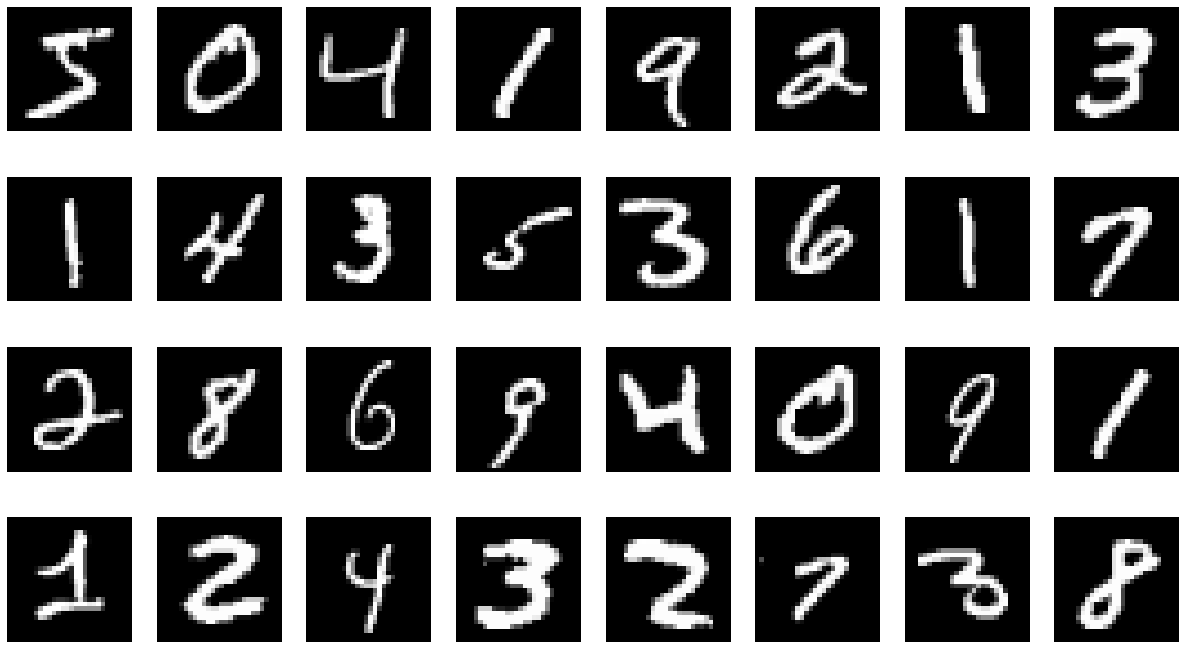

In [ ]:
plt.figure( figsize=(21, 12) )
for i in range(32):
  plt.subplot(4, 8, 1 + i)
  plt.imshow( x_train[i].reshape(28, 28), cmap='gray')
  plt.axis('off')

### Convolution(합성곱)
- 이미지에서 특징을 추출하는 기법
  - 스마트폰에서 사진을 찍고 보정하는 방법과 동일한 방법
  - 특징 맵을 추출하는 단계

- [잘 알려진 필터](https://en.wikipedia.org/wiki/Kernel_(image_processing))

몇가지 잘 알려진 필터를 적용해서 실제 이미지에 적용했을 때 어떠한 결과가 나오는지 확인해보겠습니다.

In [ ]:
# edge detection
kernel1 = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]], dtype=np.float64).reshape(3, 3, 1, 1)

# sharpen
kernel2 = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]], dtype=np.float64).reshape(3, 3, 1, 1)

# box blur
kernel3 = np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1],], dtype=np.float64).reshape(3, 3, 1, 1) * 1/9

In [ ]:
@tf.function
def convolution( img, kernel ):
  return tf.nn.conv2d( img, kernel, strides=[1, 1, 1, 1], padding='VALID')

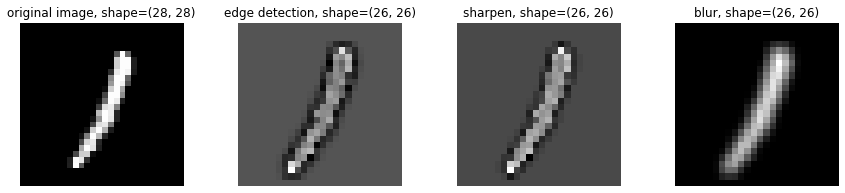

In [ ]:
img = tf.reshape( x_train[99], shape=[-1, 28, 28, 1] )
out1 = convolution( img, kernel1 )
out2 = convolution( img, kernel2 )
out3 = convolution( img, kernel3 )

plt.figure( figsize=(15, 3) )
plt.subplot( 1, 4, 1 )
plt.title(f'original image, shape={x_train[99].shape}')
plt.imshow( x_train[99], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 2 )
plt.title(f'edge detection, shape={out1[0, :, :, 0].shape}')
plt.imshow( out1[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 3 )
plt.title(f'sharpen, shape={out2[0, :, :, 0].shape}')
plt.imshow( out2[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 4 )
plt.title(f'blur, shape={out3[0, :, :, 0].shape}')
plt.imshow( out3[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.show()

#### 왜 이미지는 4차원인가?

![](https://miro.medium.com/max/1053/0*wftqg8OQ91hT0oqx.png)

#### strides
- 슬라이딩 윈도우를 하기 위한 값

![](http://incredible.ai/assets/posts/Convolutional-Neural-Networks/Convolution_schematic.gif)

#### padding
- `SAME`, `VALID`

![](https://www.researchgate.net/publication/332463100/figure/fig1/AS:748521619718145@1555472869815/An-illustration-of-padding-and-convolution-operations-in-the-CNN-model-Suppose-that-the.ppm)

### Pooling
- 추출된 특징 맵으로부터 크기를 줄여주는 단계
  - MaxPooling, AveragePooling

![](https://miro.medium.com/max/1304/1*Sh9e6Hzx8ZcOinuLvy8Fmw.png)

In [ ]:
@tf.function
def pooling( img ):
  max_pool_2d = tf.keras.layers.MaxPool2D((2, 2))
  return max_pool_2d(img)

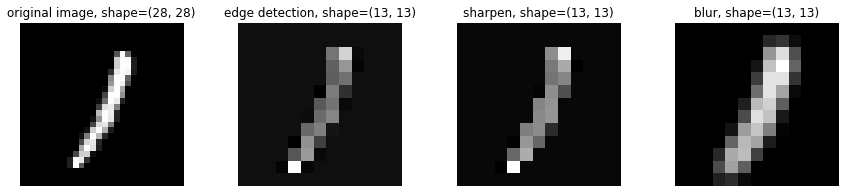

In [ ]:
ret1 = pooling( out1 )
ret2 = pooling( out2 )
ret3 = pooling( out3 )

plt.figure( figsize=(15, 3) )
plt.subplot( 1, 4, 1 )
plt.title(f'original image, shape={x_train[99].shape}')
plt.imshow( x_train[99], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 2 )
plt.title(f'edge detection, shape={ret1[0, :, :, 0].shape}')
plt.imshow( ret1[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 3 )
plt.title(f'sharpen, shape={ret2[0, :, :, 0].shape}')
plt.imshow( ret2[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot( 1, 4, 4 )
plt.title(f'blur, shape={ret3[0, :, :, 0].shape}')
plt.imshow( ret3[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.show()

## CNN의 전체 과정

처음에 입력된 2차원 이미지들은 Convolution과 pooling 단계를 거치면서    
이미지의 크기는 줄어들고, 특징은 점점 늘어나는 형태로 변환되면서,     
이미지의 큰 특징들만 남게 됩니다. 


![](https://ars.els-cdn.com/content/image/3-s2.0-B9780128157398000109-f10-08-9780128157398.jpg)


최종적으로 남은 특징맵을 1차원으로 변환한 후에 뉴럴넷의 입력으로 쓰이게 됩니다. 

# 이미지 넷(mnist)
- tr.keras.layers.Conv2D

```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    data_format=None, dilation_rate=(1, 1), groups=1, activation=None,
    use_bias=True, kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
)

```

- filter
  - 어떤 필터가 적용되는지 알 수 없습니다.
  - 적용하는 필터의 개수만 지정
- kernel_size
  - filter의 크기

In [ ]:
from pyparsing import actions
model = tf.keras.models.Sequential()

# Convolution Layer
model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
model.add( tf.keras.layers.MaxPool2D((2,2)) )
model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='tanh'))
model.add( tf.keras.layers.MaxPool2D((2,2)) )
model.add( tf.keras.layers.Conv2D(64, (3, 3), activation='tanh'))
model.add( tf.keras.layers.MaxPool2D((2,2)) )

# neural net의 입력으로 넣어주기 위해서 1차원으로 변경
model.add( tf.keras.layers.Flatten() )

# Neural Network

# hidden layer
model.add( tf.keras.layers.Dense( 4096, activation='tanh'))
model.add( tf.keras.layers.Dense( 4096, activation='tanh'))

# Output Layer
model.add( tf.keras.layers.Dense(10, activation='softmax') )

# optimization
model.compile(
  loss = 'sparse_categorical_crossentropy',
  metrics = ['accuracy'],
  optimizer = 'Adam'
)

In [ ]:
hist = model.fit(x_train, y_train, epochs=10, batch_size=1000, validation_split=0.2)

Epoch 1/10
48/48 [==============================] - 9s 174ms/step - loss: 0.5692 - accuracy: 0.8156 - val_loss: 0.1662 - val_accuracy: 0.9503
Epoch 2/10
48/48 [==============================] - 8s 163ms/step - loss: 0.1431 - accuracy: 0.9573 - val_loss: 0.1226 - val_accuracy: 0.9625
Epoch 3/10
48/48 [==============================] - 8s 163ms/step - loss: 0.1003 - accuracy: 0.9693 - val_loss: 0.1009 - val_accuracy: 0.9682
Epoch 4/10
48/48 [==============================] - 8s 163ms/step - loss: 0.0790 - accuracy: 0.9755 - val_loss: 0.0908 - val_accuracy: 0.9725
Epoch 5/10
48/48 [==============================] - 8s 163ms/step - loss: 0.0643 - accuracy: 0.9796 - val_loss: 0.0843 - val_accuracy: 0.9760
Epoch 6/10
48/48 [==============================] - 8s 163ms/step - loss: 0.0506 - accuracy: 0.9843 - val_loss: 0.0836 - val_accuracy: 0.9759
Epoch 7/10
48/48 [==============================] - 8s 163ms/step - loss: 0.0377 - accuracy: 0.9876 - val_loss: 0.0762 - val_accuracy: 0.9787
Epoch 

## loss & accuracy

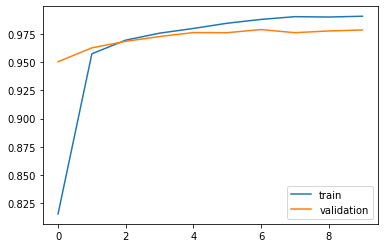

In [ ]:
plt.plot( hist.history['accuracy'], label='train')
plt.plot( hist.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

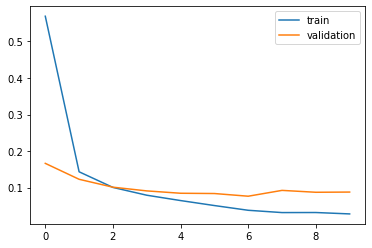

In [ ]:
plt.plot( hist.history['loss'], label='train')
plt.plot( hist.history['val_loss'], label='validation')
plt.legend()
plt.show()

## 예측
- 학습에 사용되지 않은 test 셋을 이용해서 확인

In [ ]:
print( y_test[1000] )

9


In [ ]:
yhat = model.predict( x_test )

In [ ]:
print( yhat[1000] )
print( np.argmax( yhat[1000] ) )

[5.7210968e-12 3.0048906e-09 1.2610257e-11 5.6811659e-05 5.4038582e-09
 4.5427200e-08 8.4824817e-16 7.8591273e-07 2.6280682e-07 9.9994206e-01]
9


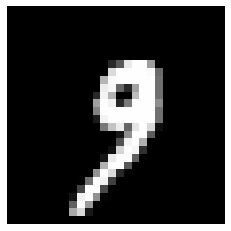

In [ ]:
plt.imshow( x_test[1000], cmap='gray')
plt.axis('off')
plt.show()